In [ ]:
# default_exp model
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Model

> In this notebook you create and test a Python class to hold your machine learning model.

***input***: toy dataset from data-notebook

***output***: TFF model for predicting customer paths 

***description:***

Model for simulating federated learning on predicting customer paths.

## Import relevant modules

In [ ]:
# tensorflow_federated_nightly also bring in tf_nightly, which
# can causes a duplicate tensorboard install, leading to errors.
#!pip uninstall --yes tensorboard tb-nightly

#!pip install --quiet --upgrade tensorflow-federated-nightly
#!pip install --quiet --upgrade nest-asyncio
#!pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

In [ ]:
# export
import numpy as np

import nest_asyncio

nest_asyncio.apply()

In [ ]:
%load_ext tensorboard

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

train_test_client_split = tff.simulation.datasets.ClientData.train_test_client_split

tff.federated_computation(lambda: "Hello, World!")()

b'Hello, World!'

In [ ]:
from pyarrow import feather
import pandas as pd

In [ ]:
from ml_federated_customer_path.data import create_tff_client_data_from_df

## Define notebook parameters

Remember, only simple assignments here!

In [ ]:
# this cell is tagged with 'parameters'
seed = 0
data_filepath = "data/preprocessed_data/data.f"
test_split = 0.2
toy_size = 0.1

NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

Make immediate derivations from the parameters:

In [ ]:
np.random.seed(seed)

## Import toy data for testing

In [ ]:
df = feather.read_feather(data_filepath)
df

,client_id,x,y
0,0,"[1, 0, 0, 0, 0, 0, 0, 0]",8
1,1,"[1, 0, 0, 0, 0, 0, 0, 0]",6
2,1,"[0, 0, 0, 0, 0, 0, 1, 0]",6
3,1,"[0, 0, 0, 0, 0, 0, 1, 0]",1
4,1,"[0, 1, 0, 0, 0, 0, 0, 0]",2
...,...,...,...
83637,9999,"[0, 1, 0, 0, 0, 0, 0, 0]",1
83638,9999,"[0, 1, 0, 0, 0, 0, 0, 0]",4
83639,9999,"[0, 0, 0, 0, 1, 0, 0, 0]",3
83640,9999,"[0, 0, 0, 1, 0, 0, 0, 0]",1


Convert into tff ClientData (training + testing datasets):

In [ ]:
client_data = create_tff_client_data_from_df(df, sample_size=0.1)
train_data, test_data = train_test_client_split(
    client_data, int(toy_size * df.client_id.nunique() * test_split)
)

In [ ]:
len(train_data.client_ids)

751

In [ ]:
len(test_data.client_ids)

200

Clear dataframe as no longer needed:

In [ ]:
df = None

## Explain the math behind

## Explore with simple scripts before constructing the model class

In [ ]:
train_data.element_type_structure

OrderedDict([('x', TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None)),
             ('y', TensorSpec(shape=(None,), dtype=tf.int32, name=None))])

In [ ]:
example_dataset = train_data.create_tf_dataset_for_client(train_data.client_ids[0])

example_element = next(iter(example_dataset))

example_dataset.element_spec
example_element["x"].numpy()

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
example_element = next(iter(example_dataset))

example_dataset.element_spec
example_element["x"].numpy()

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

## Define you ML model class

Remember that you can also create base class and subclasses to utilize heritance!

In [ ]:
def create_keras_model():
    return tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(32, kernel_initializer="zeros", input_shape=(8,)),
            tf.keras.layers.Dense(32, activation="sigmoid"),
            tf.keras.layers.Softmax(),  # tf.keras.layers.Dense(8, activation="Softmax"),
        ]
    )

In [ ]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=collections.OrderedDict(
            x=example_dataset.element_spec["x"],
            y=example_dataset.element_spec["y"],
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=1.0),
)

In [ ]:
state = iterative_process.initialize()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
# evaluation
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
iterable = train_data.create_tf_dataset_for_client(train_data.client_ids[1])

In [ ]:
d = next(iter(iterable))
d

OrderedDict([('x',
              <tf.Tensor: shape=(15, 8), dtype=uint8, numpy=
              array([[0, 0, 1, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0]], dtype=uint8)>),
             ('y',
              <tf.Tensor: shape=(15,), dtype=int32, numpy=array([4, 8, 8, 4, 2, 4, 4, 2, 2, 8, 8, 4, 2, 2, 8], dtype=int32)>)])

In [ ]:
train_data.create_tf_dataset_for_client(train_data.client_ids[0])

<PrefetchDataset shapes: OrderedDict([(x, (None, 8)), (y, (None,))]), types: OrderedDict([(x, tf.uint8), (y, tf.int32)])>

In [ ]:
len(train_data.client_ids)

751

In [ ]:
def batch_client_data(client_data, batch_size=BATCH_SIZE):
    batch = [
        client_data.create_tf_dataset_for_client(client_data.client_ids[idx])
        for idx in np.random.choice(
            np.arange(len(client_data.client_ids)), size=BATCH_SIZE
        )
    ]
    return batch

In [ ]:
def batch_client_data(client_data, batch_size=BATCH_SIZE):
    batch = [
        client_data.create_tf_dataset_for_client(client_data.client_ids[idx])
        for idx in np.random.choice(
            np.arange(len(client_data.client_ids)), size=BATCH_SIZE
        )
    ]
    return batch

In [ ]:
state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
test_metrics = evaluation(state.model, batch_client_data(test_data))

print("round  1, metrics={}".format(train_metrics))

metrics_df = pd.DataFrame(
    {
        "federated_iteration": [0],
        "train_loss": [train_metrics["train"]["loss"]],
        "train_size": [train_metrics["stat"]["num_examples"]],
        "test_loss": [test_metrics["loss"]],
    }
)  # , 'test_loss': float, 'test_size':int})

for i in range(10):
    state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
    test_metrics = evaluation(state.model, batch_client_data(test_data))
    metrics_df = pd.concat(
        (
            metrics_df,
            pd.DataFrame(
                {
                    "federated_iteration": [i + 1],
                    "train_loss": [train_metrics["train"]["loss"]],
                    "train_size": [train_metrics["stat"]["num_examples"]],
                    "test_loss": [test_metrics["loss"]],
                }
            ),
        ),
        axis=0,
    )
    print("federated_iteration  {}, metrics={}".format(i + 1, train_metrics))
metrics_df.set_index("federated_iteration", drop=True, inplace=True)
metrics_df

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.26167402), ('loss', 3.2454631)])), ('stat', OrderedDict([('num_examples', 1135)]))])
federated_iteration  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.14393939), ('loss', 2.9363399)])), ('stat', OrderedDict([('num_examples', 660)]))])
federated_iteration  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.13114753), ('loss', 2.8941145)])), ('stat', OrderedDict([('num_examples', 915)]))])
federated_iteration  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorica

,train_loss,train_size,test_loss
federated_iteration,,,
0,3.245463,1135,2.932973
1,2.936340,660,2.913030
2,2.894114,915,2.934078
3,2.884825,1000,2.896557
4,2.902472,850,2.890088
5,2.885835,990,2.899111
6,2.892352,930,2.877418
7,2.914695,770,2.860871
8,2.948760,610,2.891777


<AxesSubplot:xlabel='federated_iteration'>

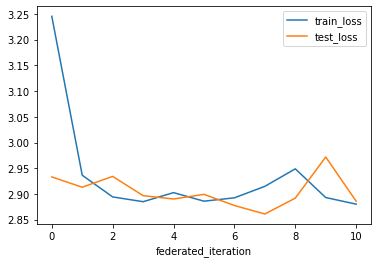

In [ ]:
metrics_df.plot(y=["train_loss", "test_loss"])

## Unit test

Unit test your class or classes

In [ ]:
# your code here

## Visualize model behaviour with toy data

In [ ]:
## your code here

## Output of this notebook

The result of this notebook is a collection methods ready for evaluation with the real data.

You should export classes and functions to `model.py` with `# nbdev_build_lib` (workflows will do this automatically).

## You can move on to loss notebook!